Prediction time will be set as before scheduled departure time, hence we will focus on CRS (scheduled times) variables.

**Columns that are excluded due to leakage would hence be:**
- DEP_TIME
- DEP_DELAY
- TAXI_OUT
- WHEELS_OFF
- WHEELS_ON
- TAXI_IN
- ARR_TIME
- ARR_DELAY
- ELAPSED_TIME
- AIR_TIME

## Checking if grouping or log normalization is necessary

We've seen in *eda.ipynb* that there might be some relationship between the scheduled depature hour and the cancellation rate. We'll test to see if there is a clearer relationship when we group different hours together.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

# Path to CSV
csv_path = "../data/flights_sample_3m.csv"

# Read the CSV into a DataFrame
df = pd.read_csv(csv_path)

In [5]:
df["dep_hour"] = df["CRS_DEP_TIME"] // 100

# Categorize departure hours into time periods
# late night: 23, 0-4 (23:00-04:59)
# morning: 5-10 (05:00-10:59)
# afternoon: 11-18 (11:00-18:59)
# night: 19-22 (19:00-22:59)
df["dep_time_period"] = np.where(
    (df["dep_hour"] >= 23) | (df["dep_hour"] <= 4), "late night",
    np.where(
        (df["dep_hour"] >= 5) & (df["dep_hour"] <= 10), "morning",
        np.where(
            (df["dep_hour"] >= 11) & (df["dep_hour"] <= 18), "afternoon",
            "night"
        )
    )
)

In [6]:
df.groupby("dep_time_period")["CANCELLED"].mean()

dep_time_period
afternoon     0.025963
late night    0.021640
morning       0.025044
night         0.031097
Name: CANCELLED, dtype: float64

Cancellation rates become kind of "normalized", and with interesting patterns like *0400hrs* having much lower cancellation rates compared to *0300hrs* and *0500hrs*, perhaps it is better to keep the departure hour separated hour-by-hour.

/var/folders/x7/df56q63s5ql81tn2cs8mx32r0000gn/T/ipykernel_2631/2146894022.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("distance_fine_bin")["CANCELLED"]


<Axes: xlabel='distance_fine_bin'>

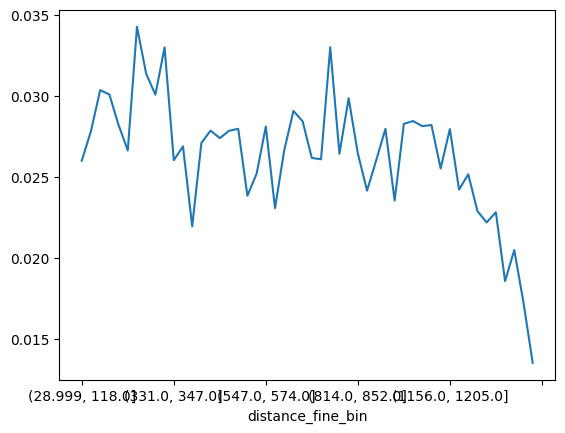

In [7]:
# Bin distance finely just for visualization
df["distance_fine_bin"] = pd.qcut(df["DISTANCE"], q=50)

cancel_rate = (
    df.groupby("distance_fine_bin")["CANCELLED"]
      .mean()
)

cancel_rate.plot()


We see that there **isn't** a very clear stepwise behavior, with exception of the very long distances. Using buckets here would throw away information and create artificial boundaries, and hence keeping distance as a continuous variable makes sense.

At short and medium distances, we see that the change in cancellation rates range from *0.003* to *0.005* for different points, but at long distances the changes are smaller at around *0.002*. Cancellation rate changes noticeably at short and medium distances compared to at long distances. Mental model is that an extra 100 miles matters less when the distance is already very long, compared to when distance is short.
Using raw distance assumes that each additional mile has the same effect on the cancellation rate. Hence we can explore a log transformation to model this diminishing effect.

<Axes: >

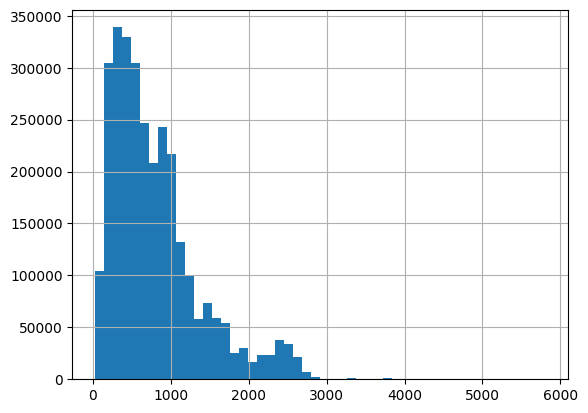

In [9]:
# Look at the distribution of distance
df["DISTANCE"].hist(bins=50)

We see that the variable *DISTANCE* is right-skewed, further supporting the use of a log transformation.

/var/folders/x7/df56q63s5ql81tn2cs8mx32r0000gn/T/ipykernel_2631/3146959914.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("log_distance_fine_bin")["CANCELLED"]


<Axes: xlabel='log_distance_fine_bin'>

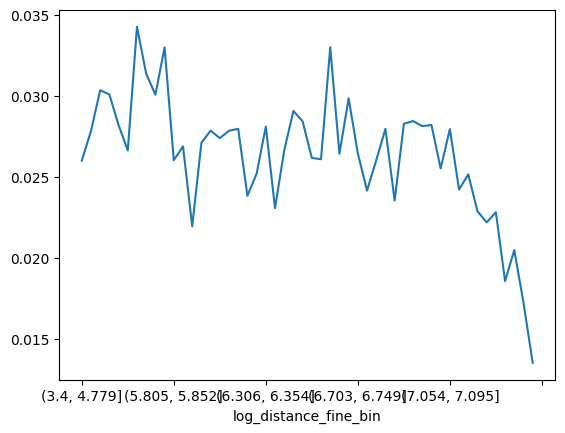

In [11]:
df["log_distance"] = np.log1p(df["DISTANCE"])

df["log_distance_fine_bin"] = pd.qcut(
    df["log_distance"],
    q=50,
    duplicates="drop"
)


cancel_rate_log = (
    df.groupby("log_distance_fine_bin")["CANCELLED"]
      .mean()
)

cancel_rate_log.plot()

However, we see that log-transforming distance **does not** really change the observed relationship between distance and cancellation rate. Therefore, we will treat distance as a continuous feature **without** transformation.

## Encoding

In [13]:
# Check cardinality of categorical variables
print("AIRLINE unique values:", df["AIRLINE"].nunique())
print("ORIGIN unique values:", df["ORIGIN"].nunique())
print("DEST unique values:", df["DEST"].nunique())


AIRLINE unique values: 18
ORIGIN unique values: 380
DEST unique values: 380


**AIRLINE (18 categories):**
- One-hot could work, but still excessive. Target encoding might be more informative

**ORIGIN/DEST (380 categories each):**
- One-hot would create way too many sparse columns
- Use frequency encoding or target encoding

In [14]:
# Frequency Encoding
# Count how often each airport appears
df["origin_freq"] = df["ORIGIN"].map(df["ORIGIN"].value_counts())
df["dest_freq"] = df["DEST"].map(df["DEST"].value_counts())

# Get proportions
df["origin_freq_proportion"] = df["ORIGIN"].map(df["ORIGIN"].value_counts(normalize=True))
df["dest_freq_proportion"] = df["DEST"].map(df["DEST"].value_counts(normalize=True))


In [18]:
                                                                                                                                                                                                                                                                       # Target Encoding for AIRLINE
# Simplified version of target encoding. Will use cross-validation for proper implementation.

# Mean cancellation rate per airline
airline_target_means = df.groupby("AIRLINE")["CANCELLED"].mean()
df["airline_target_encoded"] = df["AIRLINE"].map(airline_target_means)

print("Cancellation rate by airline:")
print(airline_target_means.sort_values())

Cancellation rate by airline:
AIRLINE
Hawaiian Airlines Inc.                0.012082
Delta Air Lines Inc.                  0.015135
Horizon Air                           0.018125
Alaska Airlines Inc.                  0.019250
Endeavor Air Inc.                     0.021287
United Air Lines Inc.                 0.021752
SkyWest Airlines Inc.                 0.022532
Spirit Air Lines                      0.024156
Frontier Airlines Inc.                0.025843
JetBlue Airways                       0.026931
American Airlines Inc.                0.028470
Envoy Air                             0.029961
PSA Airlines Inc.                     0.030836
Republic Airline                      0.032465
Southwest Airlines Co.                0.033766
Mesa Airlines Inc.                    0.036501
Allegiant Air                         0.045186
ExpressJet Airlines LLC d/b/a aha!    0.055655
Name: CANCELLED, dtype: float64


In [19]:
# Proper Target Encoding with K-Fold Cross-Validation
from sklearn.model_selection import KFold

def target_encode_kfold(df, col, target, random_state=42):
    encoded = df.copy()
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    
    # Initialize column
    encoded[f"{col}_target_encoded"] = 0.0
    
    for train_idx, val_idx in kf.split(df):
        # Calculate means on training fold
        train_means = df.iloc[train_idx].groupby(col)[target].mean()
        # Apply to validation fold
        encoded.loc[val_idx, f"{col}_target_encoded"] = df.iloc[val_idx][col].map(train_means)
        # If there are any categories in the validation fold but not in the training fold,
        # fill these missing rows with global mean
        encoded.loc[val_idx, f"{col}_target_encoded"] = encoded.loc[val_idx, f"{col}_target_encoded"].fillna(
            df.iloc[train_idx][target].mean()
        )
    
    return encoded

df = target_encode_kfold(df, "AIRLINE", "CANCELLED")
# Rename for clarity
df["airline_target_encoded_kfold"] = df["AIRLINE_target_encoded"]


In [20]:
# Compare simple vs K-Fold target encoding
print("Simple target encoding:")
print(df.groupby("AIRLINE")["airline_target_encoded"].first().head())
print("\nK-Fold target encoding:")
print(df.groupby("AIRLINE")["airline_target_encoded_kfold"].first().head())
print("\nNote: K-Fold encoding might have slight variation per row")


Simple target encoding:
AIRLINE
Alaska Airlines Inc.      0.019250
Allegiant Air             0.045186
American Airlines Inc.    0.028470
Delta Air Lines Inc.      0.015135
Endeavor Air Inc.         0.021287
Name: airline_target_encoded, dtype: float64

K-Fold target encoding:
AIRLINE
Alaska Airlines Inc.      0.019221
Allegiant Air             0.044369
American Airlines Inc.    0.028314
Delta Air Lines Inc.      0.015085
Endeavor Air Inc.         0.021255
Name: airline_target_encoded_kfold, dtype: float64

Note: K-Fold encoding might have slight variation per row


## Summary

**Final Feature Set (v1)**

- Numeric:
    - Distance (non log-transformed)

- Categorical:
    - Airline (target encoded)
    - Origin airport (frequency encoded)
    - Destination airport (frequency encoded)

- Temporal:
    - Hour of day
    - Month
    - Day of week
